
# Optimal power flow model in Julia

In [1]:
import Pkg

# activate parent environment
Pkg.activate(normpath(joinpath(@__DIR__, ".")))
Pkg.resolve()
Pkg.instantiate()
Pkg.status()

using CSV
using DataFrames
using Dates
using TimeZones
using CairoMakie
using JuMP
import JSON
import MathOptInterface as MOI

using Revise
using OptHP

  Activating project at `c:\Users\lange\OneDrive\Projects\2024\EEM25\Congestion-Management-based-on-Thermal-Comfort`
  No Changes to `C:\Users\lange\OneDrive\Projects\2024\EEM25\Congestion-Management-based-on-Thermal-Comfort\Project.toml`
    Updating `C:\Users\lange\OneDrive\Projects\2024\EEM25\Congestion-Management-based-on-Thermal-Comfort\Manifest.toml`
  [14f7f29c] + AMD v0.5.3
  [61c947e1] + Clarabel v0.9.0
  [14197337] + GenericLinearAlgebra v0.3.15
⌅ [34c5aeac] + HSL v0.4.3
⌃ [46dd5b70] + Pardiso v0.5.0
  [bfc457fd] + QDLDL v0.4.1
  [66db9d55] + SnoopPrecompile v1.0.3
  [a759f4b9] + TimerOutputs v0.5.26
  [017b0a0e] + HSL_jll v4.0.2+0
⌅ [656ef2d0] + OpenBLAS32_jll v0.3.24+0
        Info Packages marked with ⌃ and ⌅ have new versions available. Those with ⌃ may be upgradable, but those with ⌅ are restricted by compatibility constraints from upgrading. To see why use `status --outdated -m`


Status `C:\Users\lange\OneDrive\Projects\2024\EEM25\Congestion-Management-based-on-Thermal-Comfort\Project.toml`
  [336ed68f] CSV v0.10.15
  [13f3f980] CairoMakie v0.13.1
  [a93c6f00] DataFrames v1.7.0
  [682c06a0] JSON v0.21.4
  [4076af6c] JuMP v1.23.6
  [b8f27783] MathOptInterface v1.35.1
  [2d871509] OptHP v1.0.0-DEV `OptHP`
  [295af30f] Revise v3.7.2
  [f269a46b] TimeZones v1.20.0
  [ade2ca70] Dates


## Load power / user data

In [2]:
network = CSV.read("data/network.csv", DataFrame)
network.R = network.R ./ Z_base
network.X = network.X ./ Z_base
first(network, 5)

Row,StartNode,EndNode,Length,cable,Inom,R,X
,Int64,Int64,Float64,String7,Float64,Float64,Float64
1,47,15,22.21,50Al,0.12528,0.0269123,0.00356871
2,49,40,15.57,95Al,0.18386,0.00941853,0.0024135
3,26,41,18.26,95Al,0.18386,0.0110457,0.00283047
4,11,12,6.71,95Al,0.18386,0.00405898,0.00104011
5,12,27,6.52,95Al,0.18386,0.00394405,0.00101066


In [3]:
connections = CSV.read("data/user_connect.csv", DataFrame; delim=";")

# convert PV (str) to Float64
connections.PV = parse.(Float64, replace.(connections.PV, "," => "."))

first(connections, 5)

Row,Column1,Name,Node.ID,Node.Unom,Length,Type short,Connection value,load,PV,HP,Node
,Int64,Int64,Int64,Int64,String7,String15,String7,Int64,Float64,Int64,Int64
1,1,871694840006284337,46559968,230,"21,75",XLPE 4x6Cu,3x25 A,7000,4.0,1,50
2,2,871694840006288793,46563894,230,"2,22",XLPE 4x6Cu,3x25 A,7000,6.0,0,51
3,3,871694840006284108,11195660,230,"10,4",PVC 4x16Al,1x35 A,2000,2.2,0,52
4,4,871694840006284115,11195660,230,"10,4",PVC 4x16Al,1x35 A,500,2.2,0,53
5,5,871694840006284092,2573422,230,"7,33",PVC 4x16Al,1x35 A,2000,2.2,0,54


In [4]:
# define date to use for filtering
date = Date(2024, 2, 1)

# load data
path = "data/H14/H14_usage_return.csv"
loads = CSV.read(path, DataFrame)
loads.timestamp = DateTime.(loads.timestamp, "yyyy-mm-dd HH:MM:SS")
loads = loads[:, 2:3]

# we rescale usage_total_kW to usage_total_W to p.u.: 1E3 .* usage_total_kW / S_base
loads.usage_total_pu = loads.usage_total_kW ./ S_base
select!(loads, Not(:usage_total_kW))

first(loads, 5)

Row,timestamp,usage_total_pu
,DateTime,Float64
1,2024-01-17T23:00:00,0.0
2,2024-01-17T23:15:00,1.12e-5
3,2024-01-17T23:30:00,1.21333e-5
4,2024-01-17T23:45:00,1.46667e-5
5,2024-01-18T00:00:00,1.23556e-5


## Read weather data

In [5]:
weather_df = CSV.read("data/weather/weather.csv", DataFrame)
select!(weather_df, Not([:interpolated]))
rename!(weather_df, Dict("P_solar" => "Φ_s", "T_ambient" => "T_a"))

dt_format = "yyyy-mm-ddTHH:MM:SS.sss+zzzz"
weather_df.timestamp = DateTime.(ZonedDateTime.(String.(weather_df.timestamp), dt_format))
weather_df = interpolate_data(weather_df, 15)

# select a particular day (Defined in date above)
# weather_df = weather_df[Date.(weather_df.timestamp) .== date, :]

# add electricity price [€/kWh]
weather_df.λ_e .= 0.21

# convert Φ_s from W to kW
weather_df.Φ_s .= weather_df.Φ_s ./ 1000

println("Weather data shape: ", size(weather_df))
first(weather_df, 5)

Interpolating columns: [:Φ_s, :T_a]
Weather data shape: (27169, 4)


Row,timestamp,Φ_s,T_a,λ_e
,DateTime,Float64,Float64,Float64
1,2023-09-01T00:00:00,0.0,9.5,0.21
2,2023-09-01T00:15:00,0.0,9.45,0.21
3,2023-09-01T00:30:00,0.0,9.6,0.21
4,2023-09-01T00:45:00,0.0,9.5,0.21
5,2023-09-01T01:00:00,0.0,9.6,0.21


## Merge data and display

In [6]:
df_full = innerjoin(weather_df, loads, on = :timestamp);

In [7]:
# select a particular day (Defined by date)
date = Date(2024, 3, 2)

df = df_full[Date.(df_full.timestamp) .== date, :]
first(df, 5)

Row,timestamp,Φ_s,T_a,λ_e,usage_total_pu
,DateTime,Float64,Float64,Float64,Float64
1,2024-03-02T00:00:00,0.0,7.5,0.21,1.42222e-6
2,2024-03-02T00:15:00,0.0,7.45,0.21,2.48889e-6
3,2024-03-02T00:30:00,0.0,7.6,0.21,1.73333e-6
4,2024-03-02T00:45:00,0.0,7.5,0.21,1.42222e-6
5,2024-03-02T01:00:00,0.0,7.4,0.21,1.46667e-6


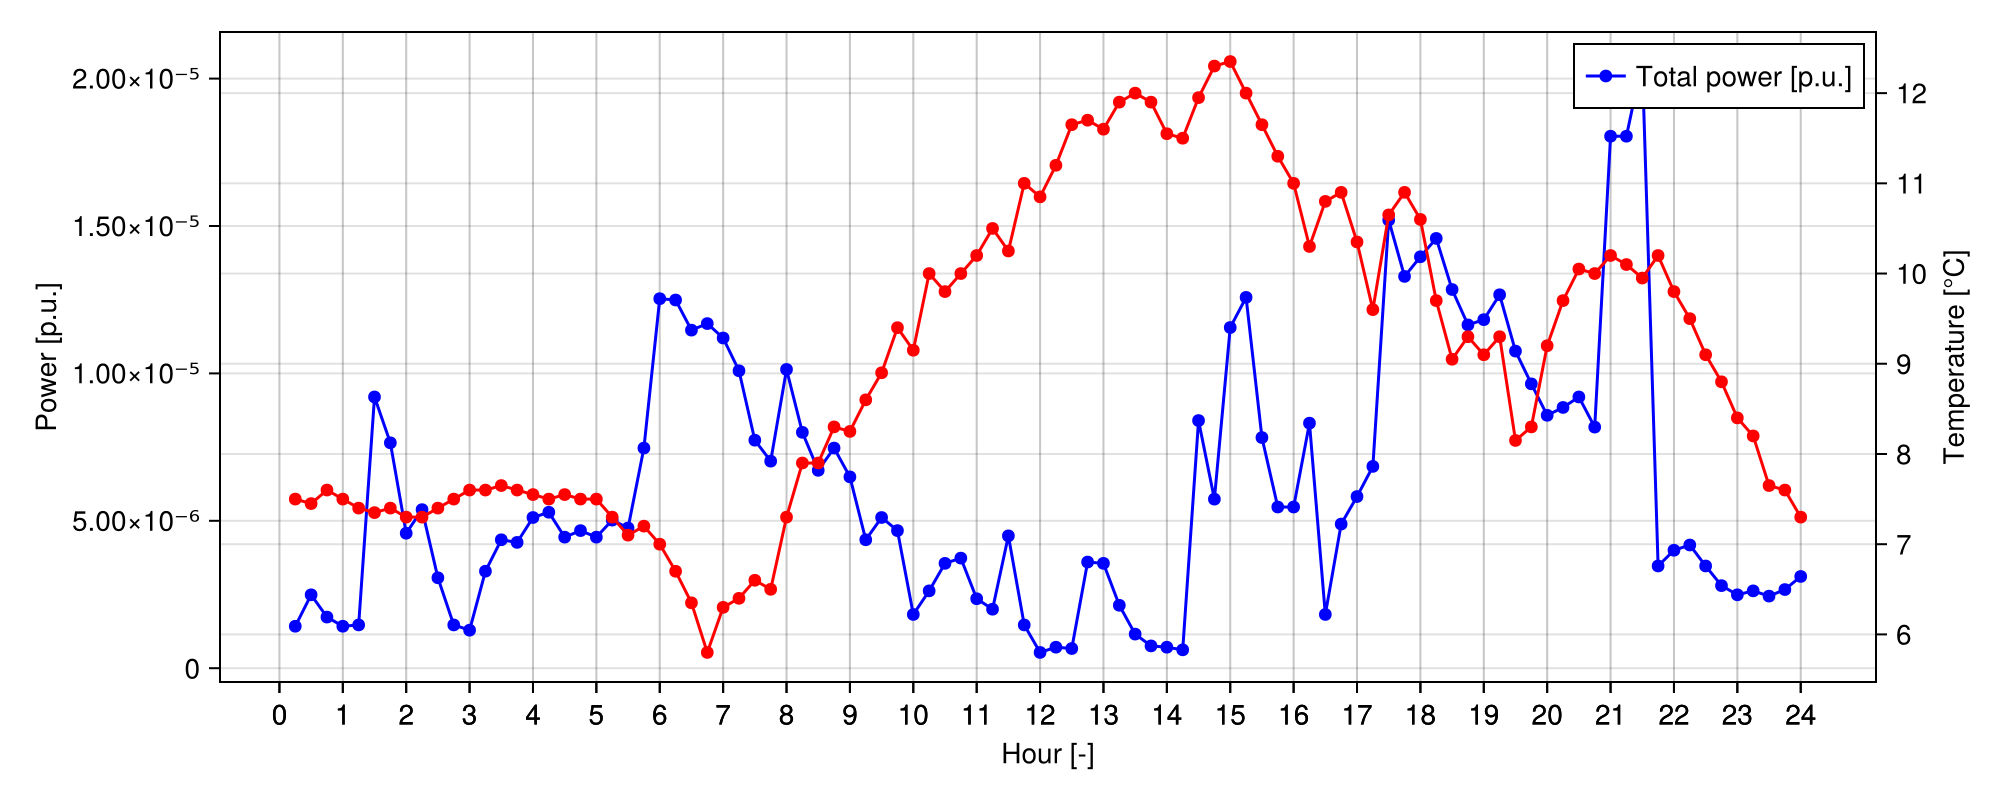

In [8]:
# plot user power data
fig = Figure(; size = (1000, 400))

ax_power = Axis(fig[1, 1], xlabel="Hour [-]", ylabel="Power [p.u.]", xticks=(0:4:96, string.(0:1:24)))
ax_temp = Axis(fig[1, 1], ylabel="Temperature [°C]", xticks=(0:4:96, string.(0:1:24)), yaxisposition = :right)

scatterlines!(ax_power, df.usage_total_pu, label="Total power [p.u.]", color=:blue)
scatterlines!(ax_temp, df.T_a, label="Temperature", color=:red)
axislegend(ax_power)
fig

## Load state-space matrices

In [9]:
id = "H14"

A_d = Matrix(CSV.read("data/$(id)/$(id)_15min_A_exact.csv", DataFrame))
B_d = Matrix(CSV.read("data/$(id)/$(id)_15min_B_exact.csv", DataFrame))

H14_meta = Dict(
    "A" => A_d,
    "B" => B_d
)

meta = Dict(
    "H14" => H14_meta
)

Dict{String, Dict{String, Matrix{Float64}}} with 1 entry:
  "H14" => Dict("B"=>[0.00663784 0.00224598 0.166439; 9.37536e-5 2.65051e-6 0.0…

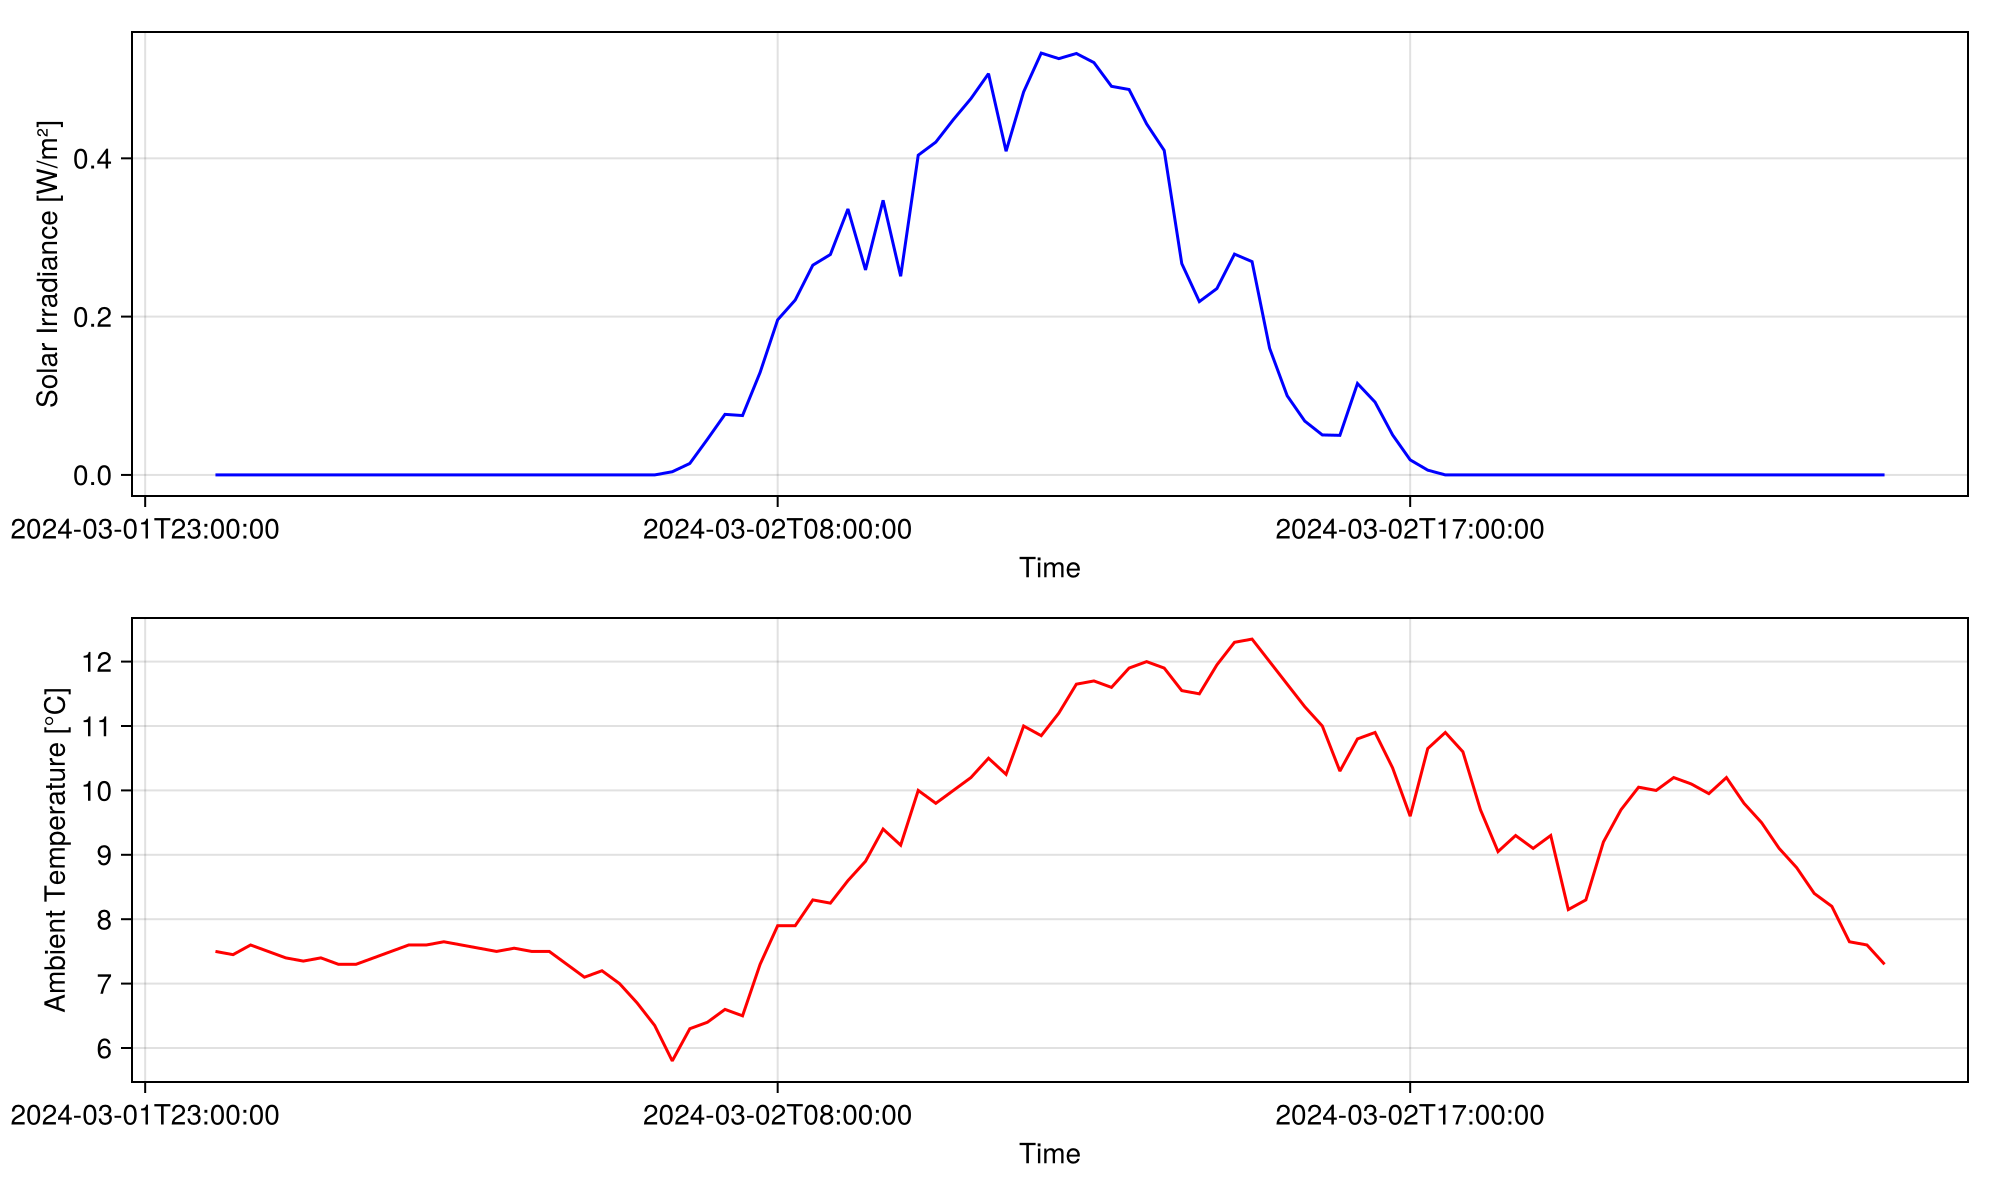

In [10]:
# plot the weather data
fig = Figure(; size = (1000, 600))

ax1 = Axis(fig[1, 1], xlabel="Time", ylabel="Solar Irradiance [W/m²]")
ax2 = Axis(fig[2, 1], xlabel="Time", ylabel="Ambient Temperature [°C]")

lines!(ax1, DateTime.(df.timestamp), df.Φ_s, color=:blue)
lines!(ax2, DateTime.(df.timestamp), df.T_a, color=:red)
fig

## Grid model with test data

## Test model

In [11]:
function plot_line_currents(model::Model, lines::Vector{Tuple{Int, Int}}=[(34, 0), (2, 74)])
    fig = Figure(; size = (1000, 600))

    I_line = value.(model[:I_line])
    for (idx,(i,j)) in enumerate(lines)
        ax = Axis(fig[idx, 1], xlabel = "Time [hours]", 
            ylabel = "Current [A]", 
            title = "($i -> $j)",
            xticks = (1:4:97, string.(0:1:24))
        )
        scatterlines!(ax, Vector(I_line[(i,j),:]), color = :blue, label = "$i->$j", linewidth = 2)
    end

    fig
end

function plot_pq(model::Model, bus::Int)
    fig = Figure(; size = (1000, 300))
    ax = Axis(fig[1, 1], xlabel = "Time [hours]", 
        ylabel = "Power [p.u.]", 
        title = "Power flow",
        xticks = (1:4:97, string.(0:1:24))
    )

    # index of slack bus (transformer)
    # SB = argmin(value.(model[:P]).axes[2])
    P_trafo = Matrix(value.(model[:P]))[bus,:]
    Q_trafo = Matrix(value.(model[:Q]))[bus,:]


    # lines!(ax, sol[:P], color = :blue, label = "Transformer", linestyle = :so
    scatterlines!(ax, P_trafo, color = :blue, label = "P trafo", linewidth = 2)
    scatterlines!(ax, Q_trafo, color = :red, label = "Q trafo", linewidth = 2)
    axislegend(ax, position = :lb)

    # display
    fig
end


plot_pq (generic function with 1 method)

In [12]:
# test network with 4 buses 
#       0   (slack)
#       |
#       1   (junction)
#      / \
#     2   3 (loads)

network_test = DataFrame(
    StartNode = [0, 1, 1],
    EndNode = [1, 2, 3],
    Length = [1.0, 1.0, 1.0],
    Inom = [0.1, 0.1, 0.1],
    R = [0.1, 0.1, 0.1],
    X = [0.2, 0.2, 0.2]
)

# correct R, X using Z_base
network_test.R = network_test.R ./ Z_base
network_test.X = network_test.X ./ Z_base

# grid connections
connections_test = DataFrame(
    HP = [0, 0],
    Node = [2, 3]
)

# loads real 
N = 96
df_test = DataFrame(
    # Symbol("usage_total_pu") => collect(range(0.1, stop = 0.2, length = N)),
    Symbol("usage_total_pu") => 0.1*ones(N),
)
println("Z_base: ", Z_base, " S_base: ", S_base, " V_base: ", V_base, " I_base: ", I_base)
first(df_test, 5)

Z_base: 0.529 S_base: 100000.0 V_base: 230.0 I_base: 434.7826086956522


Row,usage_total_pu
,Float64
1,0.1
2,0.1
3,0.1
4,0.1
5,0.1


In [13]:
model = GEC(network=network_test, 
            connections=connections_test, 
            df=df_test,
            meta = meta,
            silent=false,
            T=1:N
)

-------------------------------------------------------------
           Clarabel.jl v0.9.0  -  Clever Acronym              
                   (c) Paul Goulart                          
                University of Oxford, 2022                   
-------------------------------------------------------------

problem:
  variables     = 2016
  constraints   = 3744
  nnz(P)        = 0
  nnz(A)        = 7200
  cones (total) = 291
    : Zero        = 1,  numel = 1536
    : Nonnegative = 2,  numel = (672,384)
    : SecondOrder = 288,  numel = (4,4,4,4,...,4)

settings:
  linear algebra: direct / qdldl, precision: Float64
  max iter = 200, time limit = Inf,  max step = 0.990
  tol_feas = 1.0e-08, tol_gap_abs = 1.0e-08, tol_gap_rel = 1.0e-08,
  static reg : on, ϵ1 = 1.0e-08, ϵ2 = 4.9e-32
  dynamic reg: on, ϵ = 1.0e-13, δ = 2.0e-07
  iter refine: on, reltol = 1.0e-13, abstol = 1.0e-12, 
               max iter = 10, stop ratio = 5.0
  equilibrate: on, min_scale = 1.0e-04, max_scale = 1.0e+04


A JuMP Model
├ solver: Clarabel
├ objective_sense: MIN_SENSE
│ └ objective_function_type: AffExpr
├ num_variables: 2016
├ num_constraints: 2880
│ ├ AffExpr in MOI.EqualTo{Float64}: 1536
│ ├ Vector{AffExpr} in MOI.SecondOrderCone: 288
│ ├ VariableRef in MOI.GreaterThan{Float64}: 672
│ └ VariableRef in MOI.LessThan{Float64}: 384
└ Names registered in the model
  └ :ConicOPF, :I_line, :J_gen, :J_loss, :P, :P_line, :Q, :Q_line, :ReactiveBaseLoad, :ReactivePowerBalance, :RealBaseLoad, :RealPowerBalance, :Transmission, :VoltageDrop, :v

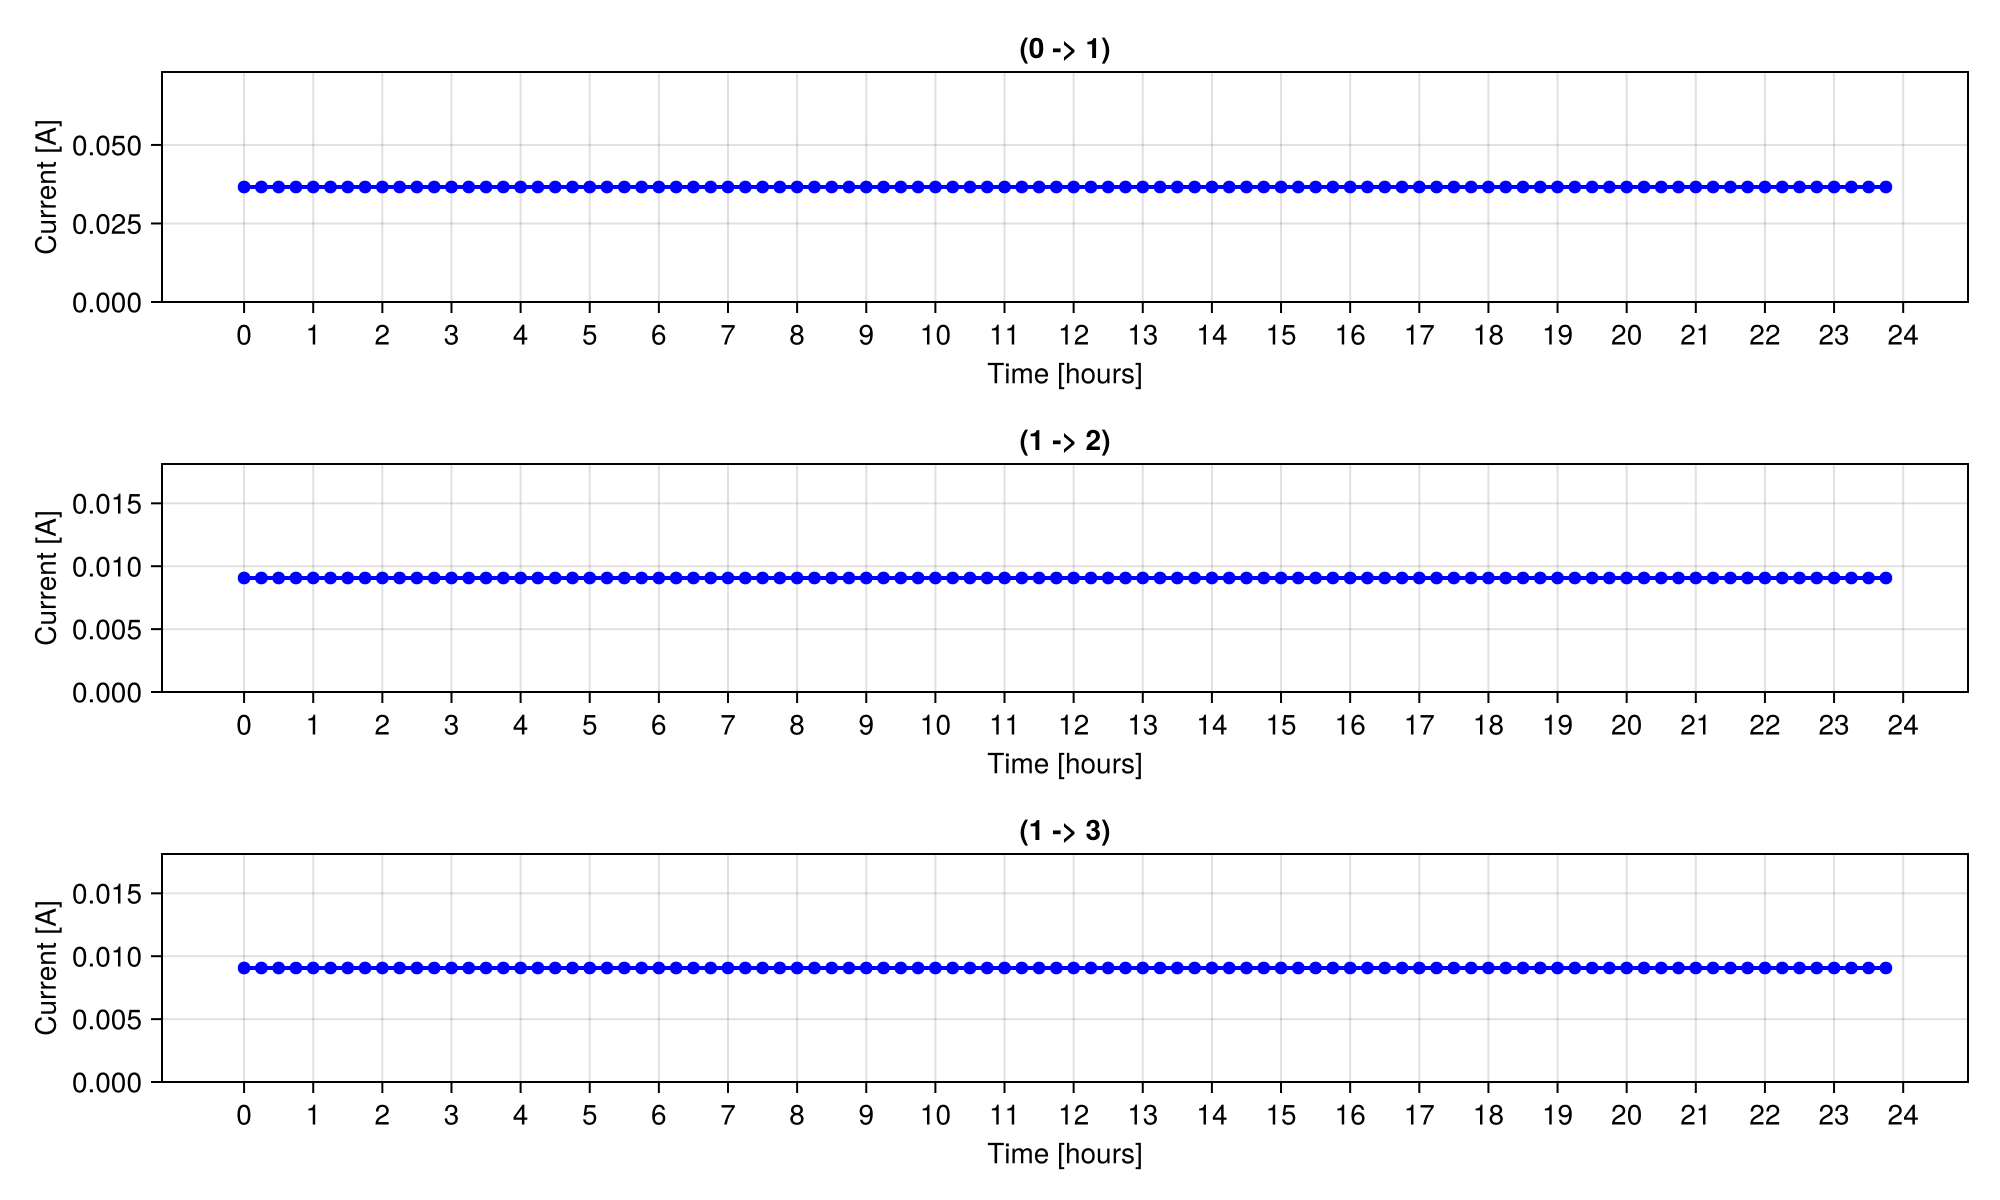

In [14]:
plot_line_currents(model, [(0,1), (1,2), (1,3)])

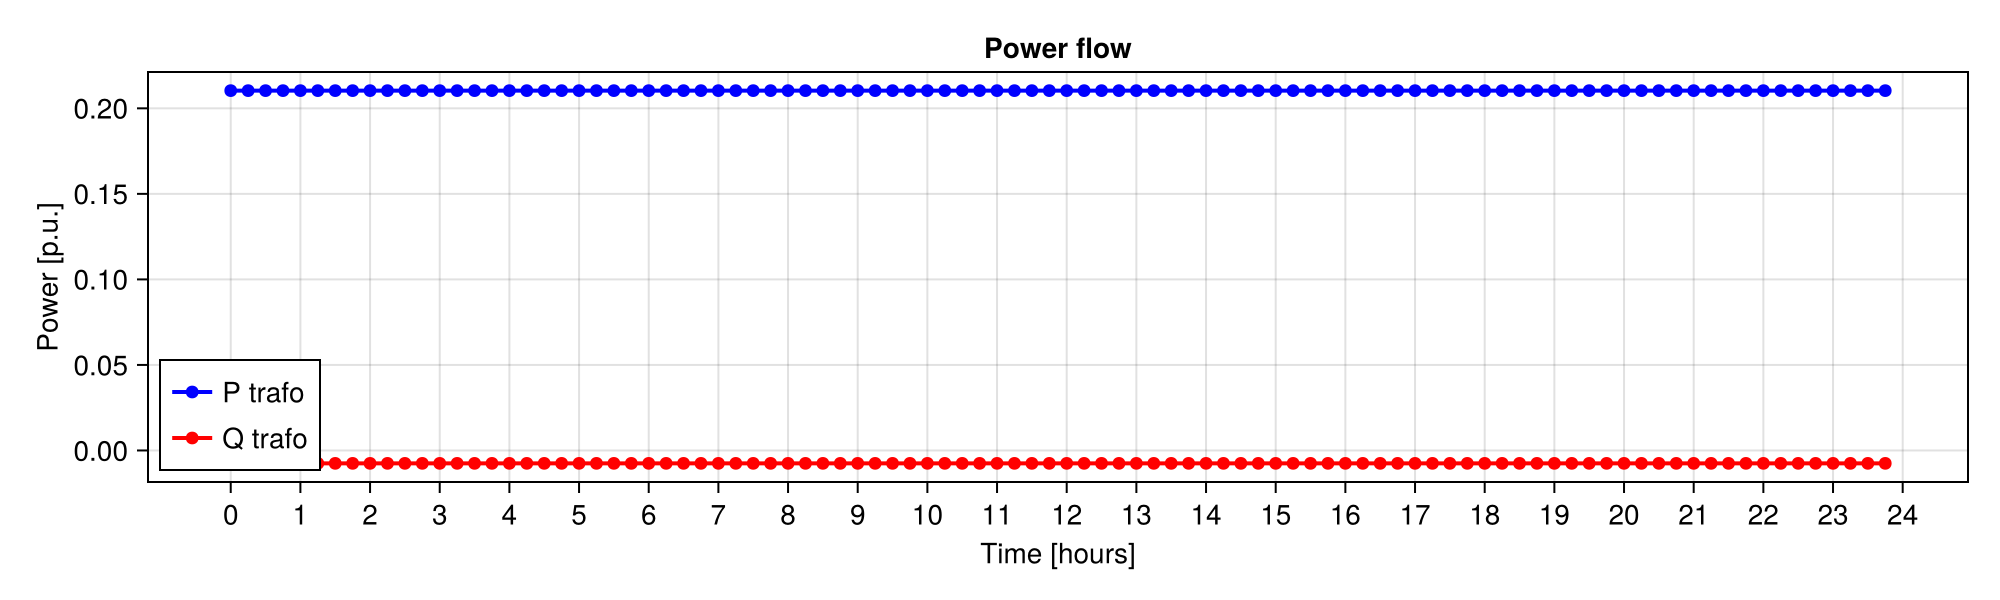

In [15]:
plot_pq(model, 1)

## Full model

In [21]:
T=1:96

1:96

In [25]:
model = GEC(network=network, 
            connections=connections,
            df=df,
            meta = meta,
            silent=false,
            T=T
)

Set parameter Username
Set parameter LicenseID to value 2599292
Academic license - for non-commercial use only - expires 2025-12-13
Set parameter BarHomogeneous to value 1
Set parameter Presolve to value 0
Set parameter BarHomogeneous to value 1
Set parameter Presolve to value 0
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 9 5950X 16-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 32 logical processors, using up to 32 threads

Non-default parameters:
BarHomogeneous  1
Presolve  0

Optimize a model with 78336 rows, 83136 columns and 210624 nonzeros
Model fingerprint: 0x970b9aa0
Model has 8352 quadratic constraints
Coefficient statistics:
  Matrix range     [4e-07, 2e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [8e-01, 1e+00]
  RHS range        [5e-07, 2e+02]
Presolve time: 0.02s
Presolved: 78336 rows, 83136 columns, 210624 nonzeros
Presolved model ha

A JuMP Model
├ solver: Gurobi
├ objective_sense: MIN_SENSE
│ └ objective_function_type: AffExpr
├ num_variables: 49824
├ num_constraints: 78336
│ ├ AffExpr in MOI.EqualTo{Float64}: 36768
│ ├ AffExpr in MOI.LessThan{Float64}: 8256
│ ├ Vector{AffExpr} in MOI.SecondOrderCone: 8352
│ ├ VariableRef in MOI.GreaterThan{Float64}: 16608
│ └ VariableRef in MOI.LessThan{Float64}: 8352
└ Names registered in the model
  └ :ConicOPF, :I_line, :J_gen, :J_loss, :LineCurrentLimit, :P, :P_line, :Q, :Q_line, :ReactiveBaseLoad, :ReactivePowerBalance, :RealBaseLoad, :RealPowerBalance, :TrafoLimit, :Transmission, :VoltageDrop, :v

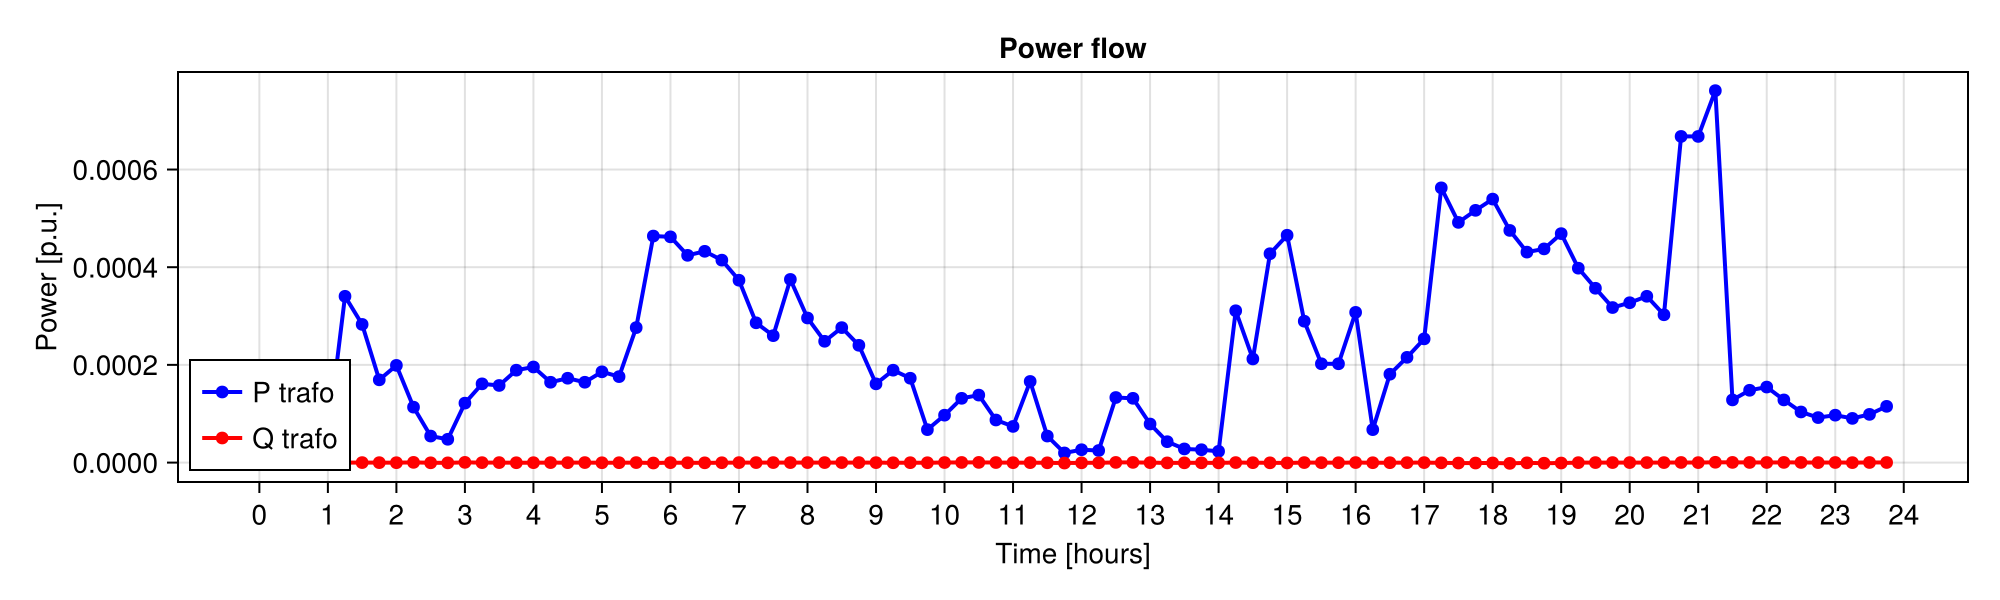

In [26]:
plot_pq(model, 55)